In [17]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class SingleDeconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.block = nn.ConvTranspose3d(in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)

    def forward(self, x):
        return self.block(x)


class SingleConv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        self.block = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=((kernel_size - 1) // 2))

    def forward(self, x):
        return self.block(x)


class Conv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleConv3DBlock(in_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class Deconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleDeconv3DBlock(in_planes, out_planes),
            SingleConv3DBlock(out_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)

class Conv3DBlock_init(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size, padding=1)
        self.bn = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))
        
class UNETR(nn.Module):
    def __init__(self, img_shape=(128, 128, 128), input_dim=4, output_dim=3, embed_dim=768, patch_size=16, num_heads=12, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = 12
        self.ext_layers = [3, 6, 9, 12]

        self.patch_dim = [int(x / patch_size) for x in img_shape]

        # U-Net Decoder
        self.decoder0 = \
            nn.Sequential(
                Conv3DBlock(input_dim, 32, 3),
                Conv3DBlock(32, 64, 3)
            )

        self.decoder3 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, 512),
                Deconv3DBlock(512, 256),
                Deconv3DBlock(256, 128)
            )

        self.decoder6 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, 512),
                Deconv3DBlock(512, 256),
            )

        self.decoder9 = \
            Deconv3DBlock(embed_dim, 512)

        self.decoder12_upsampler = \
            SingleDeconv3DBlock(embed_dim, 512)

        self.decoder9_upsampler = \
            nn.Sequential(
                Conv3DBlock(1024, 512),
                Conv3DBlock(512, 512),
                Conv3DBlock(512, 512),
                SingleDeconv3DBlock(512, 256)
            )

        self.decoder6_upsampler = \
            nn.Sequential(
                Conv3DBlock(512, 256),
                Conv3DBlock(256, 256),
                SingleDeconv3DBlock(256, 128)
            )

        self.decoder3_upsampler = \
            nn.Sequential(
                Conv3DBlock(256, 128),
                Conv3DBlock(128, 128),
                SingleDeconv3DBlock(128, 64)
            )

        self.decoder0_header = \
            nn.Sequential(
                Conv3DBlock(128, 64),
                Conv3DBlock(64, 64),
                SingleConv3DBlock(64, output_dim, 1)
            )

    def forward(self, x):
        z0, z3, z6, z9, z12 = x, *z
        # z3 = z3.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        # z6 = z6.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        # z9 = z9.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        # z12 = z12.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)

        z12 = self.decoder12_upsampler(z12)
        z9 = self.decoder9(z9)
        z9 = self.decoder9_upsampler(torch.cat([z9, z12], dim=1))
        z6 = self.decoder6(z6)
        z6 = self.decoder6_upsampler(torch.cat([z6, z9], dim=1))
        z3 = self.decoder3(z3)
        z3 = self.decoder3_upsampler(torch.cat([z3, z6], dim=1))
        z0 = self.decoder0(z0)
        output = self.decoder0_header(torch.cat([z0, z3], dim=1))
        return output

In [2]:
decoder12_upsampler = \
    SingleDeconv3DBlock(512, 512)

z12 = decoder12_upsampler(torch.randn(1, 512, 24, 24, 24))
print(z12.shape)

torch.Size([1, 512, 48, 48, 48])


In [3]:
decoder9 = \
    Deconv3DBlock(512, 512)

z9 = decoder9(torch.randn(1, 512, 24, 24, 24))
print(z9.shape)

torch.Size([1, 512, 48, 48, 48])


In [4]:
decoder9_upsampler = \
    nn.Sequential(
        Conv3DBlock(1024, 512),
        Conv3DBlock(512, 512),
        Conv3DBlock(512, 512),
        SingleDeconv3DBlock(512, 256)
    )

z9 = decoder9_upsampler(torch.cat([z9, z12], dim=1))
print(z9.shape)

torch.Size([1, 256, 96, 96, 96])


In [5]:
decoder6 = \
    nn.Sequential(
        Deconv3DBlock(512, 512),
        Deconv3DBlock(512, 256),
    )

z6 = decoder6(torch.randn(1, 512, 24, 24, 24))
print(z6.shape)

torch.Size([1, 256, 96, 96, 96])


In [6]:
decoder6_upsampler = \
    nn.Sequential(
        Conv3DBlock(512, 256),
        Conv3DBlock(256, 256),
        SingleDeconv3DBlock(256, 128)
    )

z6 = decoder6_upsampler(torch.cat([z6, z9], dim=1))
print(z6.shape)

torch.Size([1, 128, 192, 192, 192])


In [7]:
decoder3 = \
    nn.Sequential(
        Deconv3DBlock(512, 512),
        Deconv3DBlock(512, 256),
        Deconv3DBlock(256, 128)
    )

z3 = decoder3(torch.randn(1, 512, 24, 24, 24))
print(z3.shape)

torch.Size([1, 128, 192, 192, 192])


In [20]:
decoder0 = nn.Sequential(
    Conv3DBlock_init(1, 32, 3),  
    nn.Upsample(size=(384, 384, 384), mode='trilinear', align_corners=False),
    Conv3DBlock_init(32, 64, 3)
)

z0 = decoder0(torch.randn(1, 1, 240, 480, 480))
print(z0.shape)

torch.Size([1, 64, 384, 384, 384])


In [21]:
decoder0_header = \
    nn.Sequential(
        Conv3DBlock(128, 64),
        Conv3DBlock(64, 64),
        SingleConv3DBlock(64, 1, 1)
    )

output = decoder0_header(torch.cat([z0, z0], dim=1))
print(output.shape)

torch.Size([1, 1, 384, 384, 384])


In [1]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class SingleDeconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.block = nn.ConvTranspose3d(in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)

    def forward(self, x):
        return self.block(x)


class SingleConv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        self.block = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=((kernel_size - 1) // 2))

    def forward(self, x):
        return self.block(x)


class Conv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleConv3DBlock(in_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class Deconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleDeconv3DBlock(in_planes, out_planes),
            SingleConv3DBlock(out_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)

class Conv3DBlock_init(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size, padding=1)
        self.bn = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))
        
class UNETR(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, embed_dim=512):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        
        self.decoder0 = \
            nn.Sequential(
                Conv3DBlock_init(input_dim, 32, 3),  
                nn.Upsample(size=(96, 96, 96), mode='trilinear', align_corners=False),
                Conv3DBlock_init(32, 64, 3),
                Conv3DBlock(64, 256, 3)
            )

        self.decoder3 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, 512),
                Deconv3DBlock(512, 256),
                Deconv3DBlock(256, 128)
            )

        self.decoder6 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, 512),
                Deconv3DBlock(512, 256),
            )

        self.decoder9 = \
            Deconv3DBlock(embed_dim, 512)

        self.decoder12_upsampler = \
            SingleDeconv3DBlock(embed_dim, 512)

        self.decoder9_upsampler = \
            nn.Sequential(
                Conv3DBlock(1024, 512),
                Conv3DBlock(512, 512),
                Conv3DBlock(512, 512),
                SingleDeconv3DBlock(512, 256)
            )

        self.decoder6_upsampler = \
            nn.Sequential(
                Conv3DBlock(512, 256),
                Conv3DBlock(256, 256),
                SingleDeconv3DBlock(256, 128)
            )

        self.decoder3_upsampler = \
            nn.Sequential(
                Conv3DBlock(256, 128),
                Conv3DBlock(128, 128),
                SingleDeconv3DBlock(128, 64)
            )

        self.decoder0_header = \
            nn.Sequential(
                Conv3DBlock(512, 64),
                # Conv3DBlock(256, 64),
                SingleConv3DBlock(64, output_dim, 1)
            )
    
    def proj_feat(self, x, hidden_size, feat_size):
        new_view = (x.size(0), *feat_size, hidden_size)
        x = x.view(new_view)
        new_axes = (0, len(x.shape) - 1) + tuple(d + 1 for d in range(len(feat_size)))
        x = x.permute(new_axes).contiguous()
        return x

    def forward(self, image, hidden_state):
        z0, z3, z6, z9, z12 = image, *hidden_state

        # z3 = self.proj_feat(z3, 512, (24, 24, 24))
        # z6 = self.proj_feat(z6, 512, (24, 24, 24))
        z9 = self.proj_feat(z9, 512, (24, 24, 24))
        z12 = self.proj_feat(z12, 512, (24, 24, 24))

        z12 = self.decoder12_upsampler(z12)
        z9 = self.decoder9(z9)
        z9 = self.decoder9_upsampler(torch.cat([z9, z12], dim=1))
        # z6 = self.decoder6(z6)
        # z6 = self.decoder6_upsampler(torch.cat([z6, z9], dim=1))
        # z3 = self.decoder3(z3)
        # z3 = self.decoder3_upsampler(torch.cat([z3, z6], dim=1))
        z0 = self.decoder0(z0)
        print(z0.shape, z9.shape)
        output = self.decoder0_header(torch.cat([z0, z9], dim=1))
        return output

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNETR()
model.to(device)

UNETR(
  (decoder0): Sequential(
    (0): Conv3DBlock_init(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): Upsample(size=(96, 96, 96), mode='trilinear')
    (2): Conv3DBlock_init(
      (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Conv3DBlock(
      (block): Sequential(
        (0): SingleConv3DBlock(
          (block): Conv3d(64, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )
        (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
  (decoder3): Sequential(
    (0): Deconv3DBlock(
      (block): Sequential(
        (0):

In [4]:
model(torch.randn(1, 1, 240, 480, 480).to(device), [torch.randn(1, 13824, 512).to(device), torch.randn(1, 13824, 512).to(device), torch.randn(1, 13824, 512).to(device), torch.randn(1, 13824, 512).to(device)]).shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 216.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 201.12 MiB is free. Including non-PyTorch memory, this process has 23.47 GiB memory in use. Of the allocated memory 22.85 GiB is allocated by PyTorch, and 391.26 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Dataset

In [15]:
import nibabel as nib
import numpy as np

mask = nib.load(str('/share/sda/mohammadqazi/project/hector/dataset/processed_samples_all/CHUM-001_mask_roi.nii.gz')).get_fdata()

In [16]:
mask.shape, mask.min(), mask.max()

((480, 480, 240), np.float64(0.0), np.float64(2.0))

In [19]:
# get unique values in the mask

np.unique(mask, return_counts=True)


(array([0., 1., 2.]), array([55274187,     7297,    14516]))

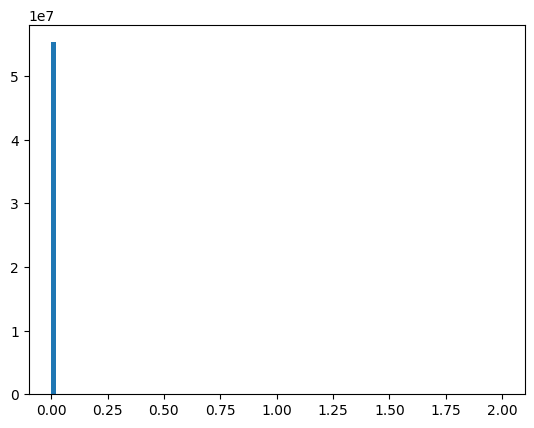

In [17]:
# get value distribution of the mask

import matplotlib.pyplot as plt

plt.hist(mask.flatten(), bins=100)

plt.show()

In [42]:
# use matplotlib to show the image
 
mask.shape

(480, 480, 240)

In [29]:
np.expand_dims(mask, axis=3).shape

(480, 480, 240, 1)

In [1]:
from data_inference_hector import Hector_Dataset_segmentation_emb

hect_dataset = Hector_Dataset_segmentation_emb(data_folder = '/share/sda/mohammadqazi/project/hector/pre_processed/',
            emd_path = "/share/sda/mohammadqazi/project/CTscan_prognosis_VLM-main/docs/embeddings/segmentation.npy",  
            csv_file ="/share/sda/mohammadqazi/project/CTscan_prognosis_VLM-main/docs/TNM_hector_prompts.csv")

train_dataset, test_dataset = hect_dataset.train_val_split(fold=0)

In [2]:
train_dataset

In [3]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

NameError: name 'DataLoader' is not defined

In [12]:
from torch import nn 
import torch
model = nn.TransformerEncoderLayer(d_model=512, nhead=4)
model(torch.randn(10, 1728, 512)).shape

torch.Size([10, 1728, 512])

In [5]:
import torch
import torch.nn as nn
from torchinfo import summary


class Downsample3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample3D, self).__init__()
        # Use a kernel size of 3, stride=2, and padding=1 to halve the spatial dimensions.
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.bn = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        # x is expected to have shape (batch, channels, D, H, W)
        return self.relu(self.bn(self.conv(x)))

# Example usage:
if __name__ == "__main__":
    # Create a dummy input tensor of shape (batch, channels, 24, 24, 24)
    x = torch.randn(1, 512, 24, 24, 24)
    # Initialize the downsampling module; here we keep the same number of channels.
    downsample = Downsample3D(in_channels=512, out_channels=512)
    # Apply the downsampling
    y = downsample(x)
    print("Input shape: ", x.shape)
    print("Output shape:", y.shape)
    # Expected output shape: (1, 512, 12, 12, 12)


Input shape:  torch.Size([1, 512, 24, 24, 24])
Output shape: torch.Size([1, 512, 12, 12, 12])


In [12]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as nnf
from torchinfo import summary


class CLIPSeg3DDecoder(nn.Module):
    def __init__(self):
        super(CLIPSeg3DDecoder, self).__init__()

        self.reduces = nn.ModuleList([nn.Linear(512, 128) for _ in range(4)])
        self.blocks = nn.ModuleList([nn.TransformerEncoderLayer(d_model=128, nhead=4) for _ in range(4)])
        self.trans_conv = nn.ConvTranspose3d(128, 1, kernel_size=3, stride=1, padding=1)
        self.downsample = nn.ModuleList([Downsample3D(in_channels=512, out_channels=512) for _ in range(4)])

    def forward(self, activations):
        
        bs = 1  
        # # Save the first activation (typically the CLS token output)
        # activation1 = activations[0]
        # # Use the rest of the activations (we have 3 in your case, since 4 total - 1 = 3)
        # activations = activations[1:]

        a = None
        for i, (activation, block, reduce, downsample) in enumerate(zip(activations, self.blocks, self.reduces, self.downsample)):
            if a is not None:
                a = reduce(downsample(activation).reshape(bs, 1728, 512)) + a
            else:
                a = reduce(downsample(activation).reshape(bs, 1728, 512))

            a = block(a)
        # print(a.shape)

        # Remove the CLS token.
        # a has shape (bs, C, 1+N) where N=1728. Remove the first token along the token dimension.
        # a = a[:, :, 1:]  # shape becomes (bs, C, 1728)

        # For 3D, permute so that we have (bs, C, tokens)
        # Then compute cube root of token count to reshape into (bs, C, D, H, W)
        num_tokens = a.shape[1]  # should be 1728
        cube_side = int(round(num_tokens ** (1/3)))  # e.g. 12
        # print(num_tokens, cube_side)
        # Reshape: assume tokens are in the last dimension
        a = a.view(bs, a.shape[2], cube_side, cube_side, cube_side)  # (bs, C, 12, 12, 12)

        # print(a.shape)

        # Apply 3D transposed convolution to upsample or refine features
        a = self.trans_conv(a)

        inp_image = torch.randn(1, 1, 240, 480, 480)
        # If n_tokens is set, upsample using trilinear interpolation to match input spatial dims
        a = nnf.interpolate(a, size=inp_image.shape[2:], mode='trilinear', align_corners=True)

        return a

# Example usage:
if __name__ == "__main__":
    # inp = torch.randn(1, 1, 240, 480, 480)
    
    # Instantiate decoder with 3 blocks (for 3 activations)
    decoder = CLIPSeg3DDecoder()
    
    # Forward pass (without conditional input)
    # output = decoder.forward([torch.randn(1, 1728, 512) for _ in range(4)])
    # print("Output shape:", output[0].shape)  # expected shape: (bs, 1, 240, 480, 480) after interpolation


    summary(decoder, input_data=[[torch.randn(1, 512, 24, 24, 24) for _ in range(4)]], depth=8, col_names=["input_size", "output_size", "num_params", 'trainable'],)

In [12]:
reduce_1 = nn.Linear(512, 128)
reduce_2 = nn.Linear(1728, 1024)
reduce_3 = nn.Linear(1728, 1024)
reduce_4 = nn.Linear(1728, 1024)

block_1 = nn.TransformerEncoderLayer(d_model=512, nhead=4)

print(reduce_1(torch.randn(1, 1728, 512)).shape, block_1(torch.randn(1, 1728, 512)).shape)


torch.Size([1, 1728, 128]) torch.Size([1, 1728, 512])


In [8]:
a = block_1(torch.randn(1, 512, 1024))
num_tokens = a.shape[2]

In [14]:
decoder = CLIPSeg3DDecoder(
    n_tokens=1728,  # example setting
)

summary(decoder, input_data=[[torch.randn(1, 512, 24, 24, 24) for _ in range(4)]], depth=8, col_names=["input_size", "output_size", "num_params", 'trainable'],)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
CLIPSeg3DDecoder                         [1, 512, 24, 24, 24]      [1, 1, 240, 480, 480]     --                        True
├─ModuleList: 1-10                       --                        --                        (recursive)               True
│    └─Downsample3D: 2-1                 [1, 512, 24, 24, 24]      [1, 512, 12, 12, 12]      --                        True
│    │    └─Conv3d: 3-1                  [1, 512, 24, 24, 24]      [1, 512, 12, 12, 12]      7,078,400                 True
│    │    └─BatchNorm3d: 3-2             [1, 512, 12, 12, 12]      [1, 512, 12, 12, 12]      1,024                     True
│    │    └─ReLU: 3-3                    [1, 512, 12, 12, 12]      [1, 512, 12, 12, 12]      --                        --
├─ModuleList: 1-11                       --                        --                        (recursive)               True
│    